In [1]:
import uproot
import matplotlib.pyplot as plt
import hist as Hist
import numpy as np

In [ ]:
def build_spline(hist):
    '''
        Builds a cubic spline to interpolate the energy sharing
        distribution histogram
    '''
    from scipy.interpolate import UnivariateSpline, CubicSpline
    
    centers = hist.axes[0].centers

    amps = hist.values()/np.amax(hist.values())

    spline = CubicSpline(centers, amps, extrapolate = False)

    return spline

In [ ]:
ref_data = './BNL_Signal_Response.root'

f = uproot.open(ref_data)

h = f['pmax_histogram'].to_hist()

defaultspline = build_spline(h)

h.plot()

h.axes

In [ ]:
tfile = uproot.recreate('testfile.root')
tfile.keys()

In [ ]:
tfile['hist'] = np.histogram(np.random.normal(0, 1, 10000))

In [ ]:
tfile['branch/leaf/fruit'] = np.histogram(np.random.normal(0, 1, 10000))

In [ ]:
with uproot.open('testfile.root') as f:
    k =f.keys()
    print(k)
    h =f['hist'].to_hist()
    h.plot()


In [ ]:
#Successfully deleted a branch 


file = uproot.update('/home/dylan/pioneer/atar_waveform/dylansversion/testfile.root')

print(file.show())

del file['hist']

print(file.keys())

In [ ]:
source = r'/home/dylan/pioneer/atar_waveform/dylansversion/testfile.root'
dest = os.getcwd() + "/digitized.root"
shutil.copyfile(source, dest)


In [ ]:
with uproot.open('digitized.root')  as tfile:
    print(tfile.keys())

In [ ]:
atar_data = uproot.open('/home/dylan/pioneer/simulationdata/pienux_out_stripped.root:atar')
atar_data.keys()

In [ ]:
import os 
import shutil

tdict = {'k1':[1, 2, 3], 'k2':[3, 4, 5]}
root_path = r'/home/dylan/pioneer/simulationdata/pienux_out_stripped.root'

dest = os.getcwd() + '/digitized' + os.path.basename(root_path)

shutil.copy(root_path, dest) 



with uproot.update(dest) as f:
    f['digitizedatar'] = {'b1':np.arange(1000)}

with uproot.open(dest) as f:
    print(f.keys())
    print(f['digitizedatar'].keys())
    h = f['digitizedatar']['b1']
    print(h.array())
    

    
     





In [6]:
with uproot.open('/home/dylan/pioneer/atar_waveform/dylansversion/digitizedpienux_out_stripped.root:digitized_atar') as f:
    print(f.keys())

['pixel_pdg', 'pixel_edep', 'pixel_time', 'pixel_hits']


In [1]:
class new_digitizeatar:

    '''
        This class computes energy sharing in the Atar. It has methods to build a spline
        and return atar data with energysharing computed. You must initialized the class
        with a path to a histogram to build the spline. This spline, once built, can be
        passed into the compute energysharing method to return updated data. 
    '''

    #The following are class variables based on Atar simulation parameters. 


    pixels_per_plane = 100
    pixel_pitch = 200



    #Here is a given path to a spline './BNL_Signal_Response.root'

    def __init__(self, path_to_spline):
        
        #Energysharing spline path must be provided by the user. 

        self.path_to_spline =  path_to_spline


    #For the paramaters in the atar simulation, the number of slits accessible on either side is two.

    def get_adjacent_strips(self, pixel, pixels_per_plane = pixels_per_plane, n = 2):
        '''
        Returns n adjacent strips within the same plane from a given strip (pixel). 
        N is determined by the spline width and can be adjusted as necessary. 
        Assumed pixel pitch of 200 microns and a spline width of 600 microns.
        '''
        return [(pixel + x) for x in range(-n, n+1) if int(np.ceil(float((pixel + x)/pixels_per_plane))) == int(np.ceil(float(pixel)/pixels_per_plane))]
        


    def build_spline(self):
        '''
            Builds a cubic spline to interpolate the energy sharing
            distribution histogram. Has a default spline if no other data is given.
        '''

        with uproot.open(self.path_to_spline) as f:

            h = f['pmax_histogram'].to_hist()


            from scipy.interpolate import UnivariateSpline, CubicSpline

            centers = h.axes.centers[0]
            
            amps = h.values()/np.amax(h.values())

            spline = CubicSpline(centers, amps, extrapolate = False)

        return spline


    def compute_energy_sharing(self, root_path, spline, entry, pixel_pitch = 200):

        '''
        Returns a digitized form atar pixel data in dictionary form
        '''

        dest = os.getcwd() + '/digitized' + os.path.basename(root_path)

        shutil.copy(root_path, dest)


        

        tree = {
            'pixel_pdg':[],
            'pixel_edep':[],
            'pixel_time':[],
            'pixel_hits':[]
        }

        

        data = root_path['atar'].arrays(['pixel_pdg', 'pixel_edep', 'pixel_time', 'pixel_hits'])
        pdg = data['pixel_pdg'][entry]
        edep = data['pixel_edep'][entry]
        time = data['pixel_time'][entry]
        hits = data['pixel_hits'][entry]

     
            
        for i, hiti in enumerate(hits):
            #Loop over all hits and calculate energy sharing

            these_energies = []
                    
            for j, pos in enumerate(self.get_adjacent_strips(hiti)):
                energy_position = (pos - hiti) * pixel_pitch
                energyi = spline(energy_position)*edep[i]
                these_energies.append(energyi)
            
            #Normalize the energies to conserve energy
            these_energies = np.array(these_energies) * (edep[i]/np.sum(these_energies))

            # print("total Energy", np.sum(these_energies), edep[i])

            output['pixel_edep'] += list(these_energies)
            output['pixel_hits'] += self.get_adjacent_strips(hiti)
            output['pixel_time'] += list(np.full_like(these_energies, time[i]))
            output['pixel_pdg'] += list(np.full_like(these_energies, pdg[i], dtype=int))


        with uproot.update(dest) as f:
            f['digitizedatar'] = tree
            



IndentationError: expected an indented block (2091542556.py, line 113)

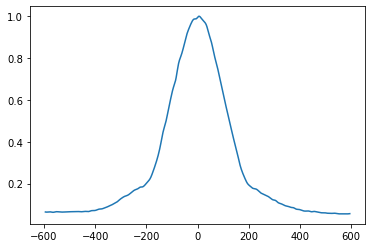

In [8]:
from energy_sharingv2 import new_digitizeatar

path_to_hist = "./BNL_Signal_Response.root"

root_path = '/home/dylan/pioneer/simulationdata/pienux_out_stripped.root'


class_version = new_digitizeatar(path_to_hist, pixel_pitch= 50)

spline = class_version.build_spline()
f = uproot.open(path_to_hist)
h = f['pmax_histogram'].to_hist()
out = class_version.build_spline()
xs = np.linspace(h.axes[0].centers[0], h.axes[0].centers[-1], 1000)
ys = class_version.build_spline()(xs)
fig, ax = plt.subplots()
plt.plot(xs, ys)

class_version.compute_energy_sharing(root_path, spline, entry = 0)




In [35]:
shared = '/home/dylan/pioneer/atar_waveform/dylansversion/digitizedpienux_out_stripped.root'

with uproot.open(shared) as f:
    print(f.keys())

['init;1', 'atar;1', 'calorimeter;1', 'sipm;1', 'hit_location_outer_surface;1', 'calo_outer_surface;1', 'degrader;1', 'beampipe;1', 'decay;1', 'digitizedatar;1']


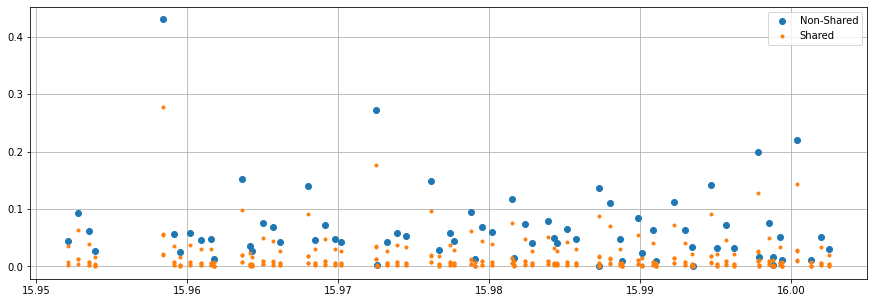

In [7]:

import awkward as ak

atar = uproot.open('/home/dylan/pioneer/simulationdata/pienux_out_stripped.root:atar')

shared = uproot.open('/home/dylan/pioneer/atar_waveform/dylansversion/digitizedpienux_out_stripped.root:digitized_atar')

fig,ax = plt.subplots(figsize=(15,5))
plt.plot(atar['pixel_time'].array()[0], atar['pixel_edep'].array()[0],"o", label='Non-Shared')
plt.plot(shared['pixel_time'], shared['pixel_edep'],".", label='Shared')

plt.grid()
plt.legend()
plt.show()

In [16]:
modded_file = '/home/dylan/pioneer/atar_waveform/dylansversion/digitizedpienux_out_stripped.root'

with uproot.open(modded_file) as f:
    print(f['digitizedatar'].keys())
    data = f['digitizedatar']['pixel_edep'].array()
    print(sum(data))

['pixel_pdg', 'pixel_edep', 'pixel_time', 'pixel_hits']
4.803319554423562


In [15]:
atar_data = uproot.open('/home/dylan/pioneer/simulationdata/pienux_out_stripped.root:atar')


actual_data = atar_data['pixel_edep'].array()
print('actual data energy:', sum(actual_data[0]), 'number of pixels hit:', len(actual_data[0]))



actual data energy: 4.80331955442356 number of pixels hit: 72


In [10]:
#Cant copy tree objects yet

modded_file.
root_path = '/home/dylan/pioneer/simulationdata/pienux_out_stripped.root'
r = uproot.open(root_path)
with uproot.update(modded_file) as f:
    f.copy_from(r, filter_name="/atar/", rename = '/from/to')



NameError: name 'modded_file' is not defined

In [9]:
a = uproot.update('/home/dylan/pioneer/atar_waveform/dylansversion/digitizedpienux_out_stripped.root')
a.